# 📘 Time Series Analysis Basics & Foundation Models
This notebook covers the **basics of time series analysis** using a sample dataset. We will go step by step from fundamentals to ARIMA model building and evaluation.

## 1. Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## 2. Load Sample Dataset

In [5]:
df = pd.read_csv('sample_time_series.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Sales
Date,
2015-01-01,54.967142
2015-02-01,52.177215
2015-03-01,63.577121
2015-04-01,75.832141
2015-05-01,61.704239


## 3. Visualize Time Series
We will look for trend, seasonality, and noise.

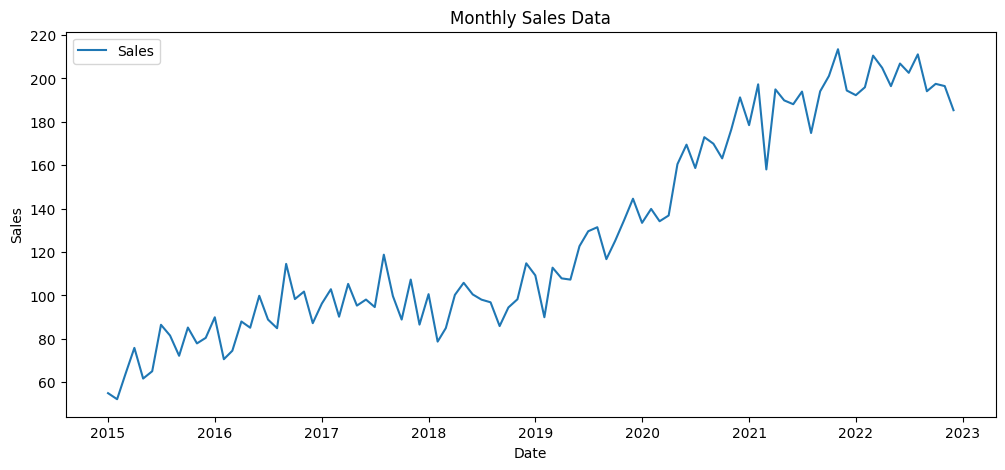

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Sales'], label='Sales')
plt.title('Monthly Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 4. Stationarity Check (ADF Test)
Stationarity means constant mean, variance, and correlation over time.

In [7]:
result = adfuller(df['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print('Series is Stationary')
else:
    print('Series is Non-Stationary')

ADF Statistic: -0.40575810862821576
p-value: 0.9091329311262728
Series is Non-Stationary


## 5. Differencing (to make stationary if needed)

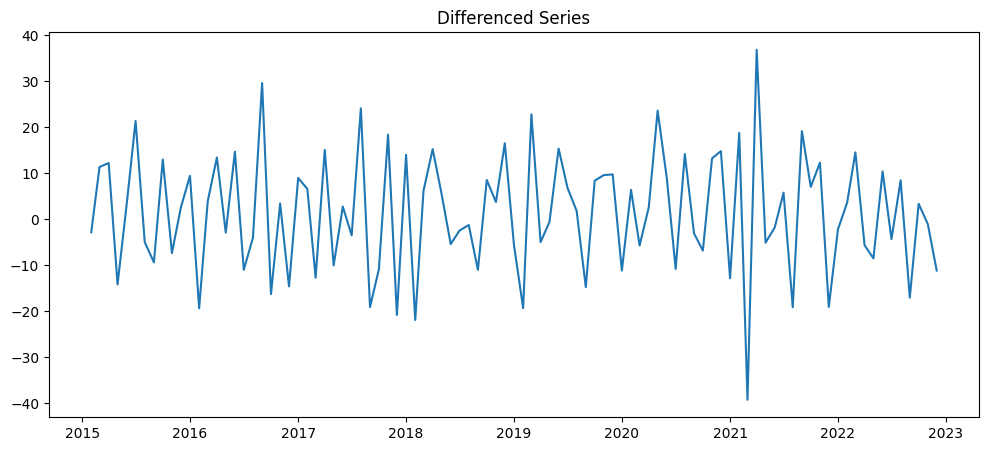

In [8]:
df_diff = df['Sales'].diff().dropna()
plt.figure(figsize=(12,5))
plt.plot(df_diff)
plt.title('Differenced Series')
plt.show()

## 6. ACF & PACF Plots
These help us choose AR (p) and MA (q) orders.

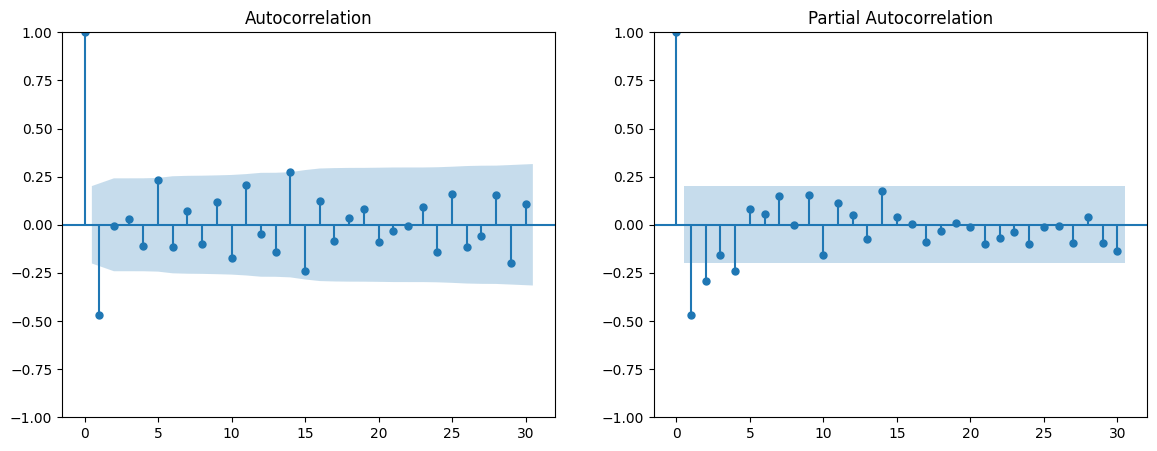

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_acf(df_diff, ax=ax[0], lags=30)
plot_pacf(df_diff, ax=ax[1], lags=30)
plt.show()

## 7. Simple Forecasting Methods

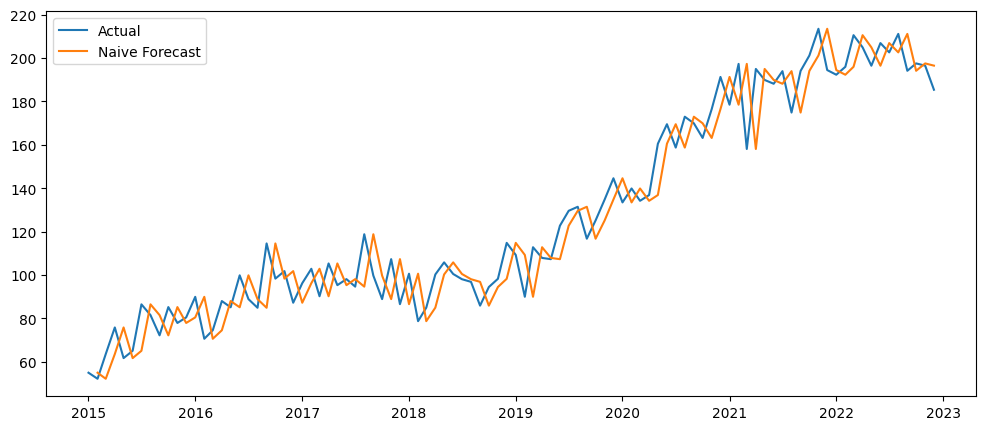

In [10]:
# Naive Forecast
naive_forecast = df['Sales'].shift(1)
plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label='Actual')
plt.plot(naive_forecast, label='Naive Forecast')
plt.legend()
plt.show()

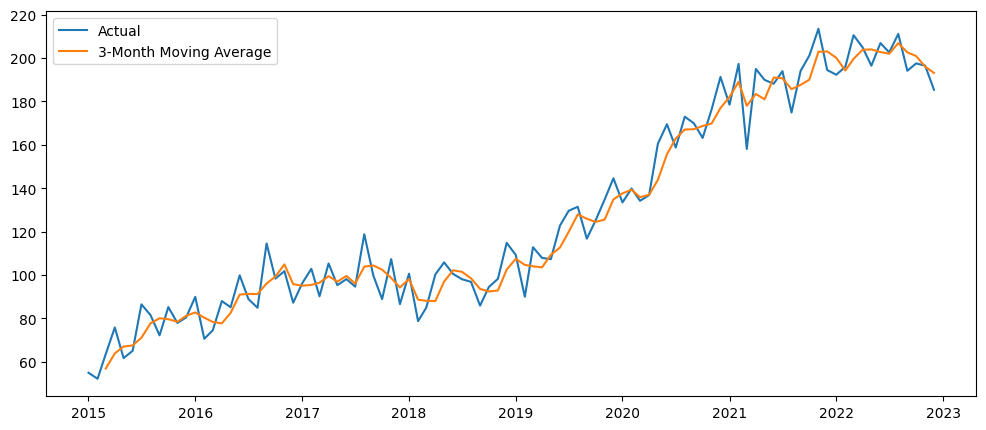

In [11]:
# Moving Average Forecast
rolling_mean = df['Sales'].rolling(window=3).mean()
plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label='Actual')
plt.plot(rolling_mean, label='3-Month Moving Average')
plt.legend()
plt.show()

## 8. ARIMA Model
We will fit an ARIMA model and evaluate using AIC/BIC.

In [12]:
model = ARIMA(df['Sales'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   96
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -364.509
Date:                Sun, 17 Aug 2025   AIC                            739.019
Time:                        13:33:39   BIC                            751.788
Sample:                    01-01-2015   HQIC                           744.179
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0441      0.207     -5.039      0.000      -1.450      -0.638
ar.L2         -0.2380      0.186     -1.281      0.200      -0.602       0.126
ma.L1          0.4711      0.203      2.316      0.0

## 9. Forecasting with ARIMA

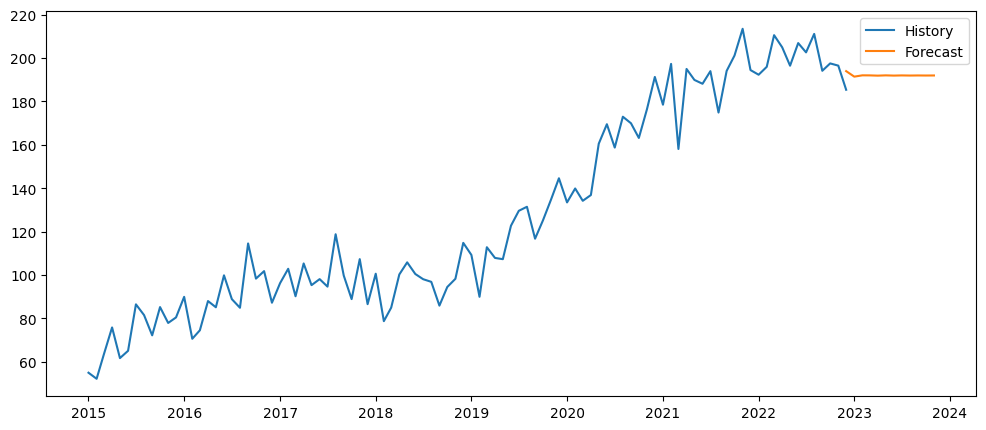

In [13]:
forecast = model_fit.forecast(steps=12)
plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label='History')
plt.plot(pd.date_range(df.index[-1], periods=12, freq='MS'), forecast, label='Forecast')
plt.legend()
plt.show()

## 10. Model Evaluation (Train-Test Split)
Using MAE, RMSE, and MAPE.

In [14]:
train = df.iloc[:-12]
test = df.iloc[-12:]

model = ARIMA(train['Sales'], order=(2,1,2))
model_fit = model.fit()
pred = model_fit.forecast(steps=12)

mae = mean_absolute_error(test['Sales'], pred)
rmse = np.sqrt(mean_squared_error(test['Sales'], pred))
mape = np.mean(np.abs((test['Sales'] - pred) / test['Sales'])) * 100

print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape, '%')

MAE: 6.920268519261032
RMSE: 7.959348152505574
MAPE: 3.499530381931437 %


In [15]:
print('AIC:', model_fit.aic)
print('BIC:', model_fit.bic)

AIC: 652.6655294001163
BIC: 664.7597324390993


## Define parameter grid

Specify a range of values for p, d, and q to explore.

**Reasoning**:
Create lists for the possible values of p, d, and q parameters for the ARIMA model.



In [16]:
p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

## Iterate and fit arima models

### Subtask:
Loop through all combinations of p, d, and q, fit an ARIMA model for each combination, and store the AIC and BIC scores. Handle potential convergence warnings.


**Reasoning**:
Initialize a list to store the results and then loop through the parameter combinations, fit the ARIMA model, and store the AIC and BIC scores.



In [17]:
results = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                model = ARIMA(train['Sales'], order=order)
                model_fit = model.fit()
                results.append({
                    'order': order,
                    'AIC': model_fit.aic,
                    'BIC': model_fit.bic
                })
            except:
                print(f'Failed to fit ARIMA for order: {order}')

## Find best parameters

### Subtask:
Identify the combination of p, d, and q that resulted in the lowest AIC and BIC scores.


**Reasoning**:
Create a pandas DataFrame from the results list, sort it by AIC and BIC, and print the best parameters.



In [18]:
results_df = pd.DataFrame(results)
print("Best parameters based on AIC:")
print(results_df.sort_values(by='AIC').head(1))
print("\nBest parameters based on BIC:")
print(results_df.sort_values(by='BIC').head(1))

Best parameters based on AIC:
       order         AIC         BIC
8  (0, 2, 2)  635.716926  642.937084

Best parameters based on BIC:
       order         AIC         BIC
8  (0, 2, 2)  635.716926  642.937084


## Fit and evaluate the best model

### Subtask:
Fit the ARIMA model with the best parameters on the training data and evaluate its performance using MAE, RMSE, and MAPE on the test data.


**Reasoning**:
Fit the ARIMA model with the best parameters (0, 2, 2) on the training data and evaluate its performance using MAE, RMSE, and MAPE on the test data.



In [19]:
model = ARIMA(train['Sales'], order=(0, 2, 2))
model_fit = model.fit()
pred = model_fit.forecast(steps=len(test))

mae = mean_absolute_error(test['Sales'], pred)
rmse = np.sqrt(mean_squared_error(test['Sales'], pred))
mape = np.mean(np.abs((test['Sales'] - pred) / test['Sales'])) * 100

print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape, '%')

MAE: 11.07105005788136
RMSE: 14.202663496526142
MAPE: 5.69732589890037 %


## Summary:

### Data Analysis Key Findings

*   The hyperparameter tuning process explored ARIMA model orders with p, d, and q values ranging from 0 to 2 for each parameter.
*   All combinations within the specified range were successfully fitted without convergence errors.
*   Based on both the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC), the optimal ARIMA model order among the tested combinations was identified as (0, 2, 2).
*   The fitted ARIMA(0, 2, 2) model on the training data yielded the following performance metrics on the test data:
    *   Mean Absolute Error (MAE): 11.07
    *   Root Mean Squared Error (RMSE): 14.20
    *   Mean Absolute Percentage Error (MAPE): 5.70%

### Insights or Next Steps

*   The identified optimal parameters (0, 2, 2) provide a starting point for forecasting.
*   Further analysis could involve exploring a wider range of p, d, and q values or incorporating external regressors to potentially improve model performance.
